In [1]:
# import library
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

2023-12-08 06:07:22.737886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Volumes/DataQ/Tugas Akhir/lstm-predict-potato-price/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# create dataframe from csv file
pick_harga = 'KTG'
data = pd.read_csv(f'../data/timeseries-{pick_harga}-wonosobo.csv', index_col='tanggal', parse_dates=True)
data

,harga
tanggal,
2021-01-01,9000.0
2021-01-02,9000.0
2021-01-03,9000.0
2021-01-04,9000.0
2021-01-05,9000.0
...,...
2023-12-03,11000.0
2023-12-04,11000.0
2023-12-05,11000.0


<Axes: xlabel='tanggal'>

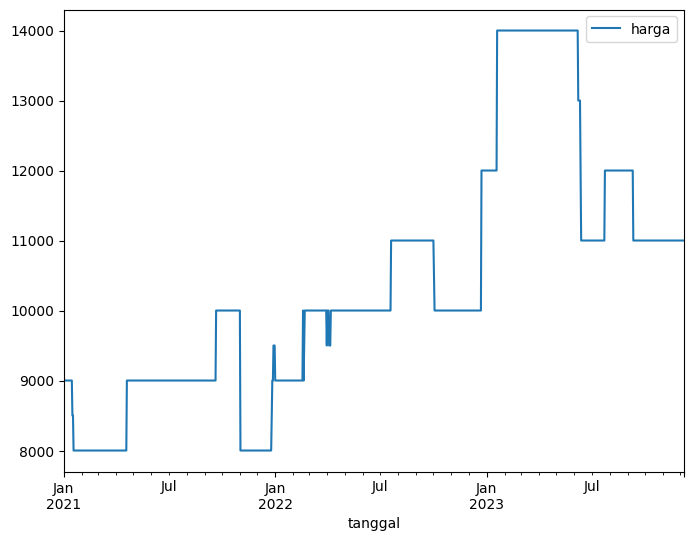

In [3]:
# plot data
data.plot()

In [4]:
# Scaling Data menggunakan minmax scaller
min_max_scaler = MinMaxScaler(feature_range=(1, 2))
dataset = min_max_scaler.fit_transform(
    data['harga'].values.reshape(-1, 1)
    )

In [5]:
data_awal = data['harga'].values.reshape(-1)
data_minmax = dataset.reshape(-1)
# data_predict
new_df = {
    "data asli" : data_awal,
    "min-max": data_minmax
}

dataframe = pd.DataFrame(new_df)
dataframe.sample(10)
# data_minmax

,data asli,min-max
596,11000.0,1.500000
315,8000.0,1.000000
264,10000.0,1.333333
999,11000.0,1.500000
378,9000.0,1.166667
251,9000.0,1.166667
611,11000.0,1.500000
992,11000.0,1.500000
1067,11000.0,1.500000
652,10000.0,1.333333


In [6]:
# split data menjadi data train dan data validasi
train_size = int(len(dataset) * 0.8)
validation_size = len(dataset) - train_size
train, validation = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(validation))

856 215


In [7]:
# membuat fungsi window dataset
def windowed_dataset(dataset, window_size=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-window_size-1):
        a = dataset[i:(i+window_size), 0]
        dataX.append(a)
        dataY.append(dataset[i + window_size, 0])
    return np.array(dataX), np.array(dataY)

In [8]:
# Parameters
window_size = 20

# membuat window data train dan validation
x_train, y_train = windowed_dataset(train, window_size)
x_validation, y_validation = windowed_dataset(validation, window_size)
x_train[0]


array([1.16666667, 1.16666667, 1.16666667, 1.16666667, 1.16666667,
       1.16666667, 1.16666667, 1.16666667, 1.16666667, 1.16666667,
       1.16666667, 1.16666667, 1.16666667, 1.16666667, 1.16666667,
       1.08333333, 1.08333333, 1.        , 1.        , 1.        ])

<module 'matplotlib.pyplot' from '/Volumes/DataQ/Tugas Akhir/lstm-predict-potato-price/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

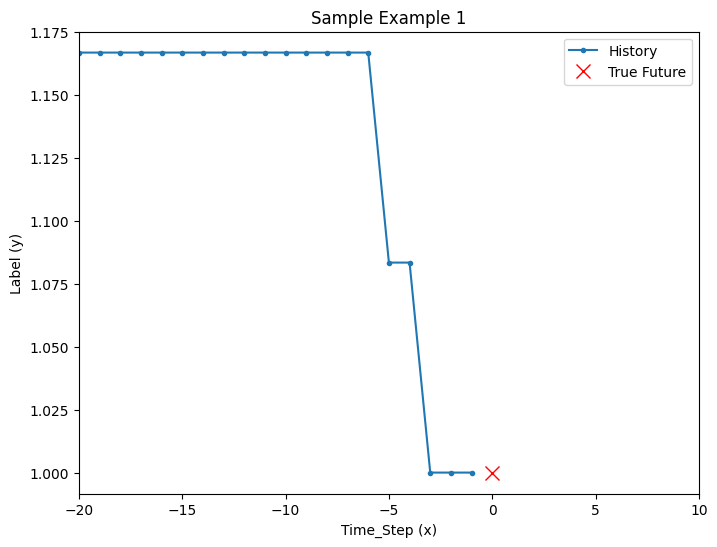

In [9]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step (x)')
  plt.ylabel('Label (y)')

  return plt

plot_time_series([x_train[0] , y_train[0]] , 0 , 'Sample Example 1')

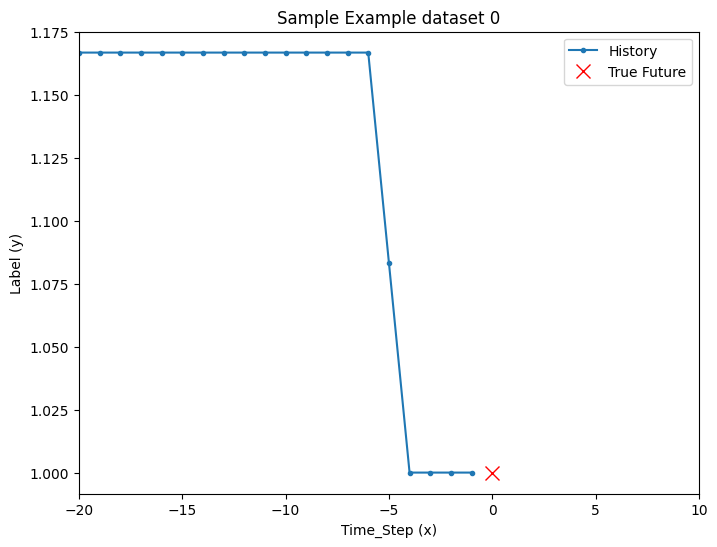

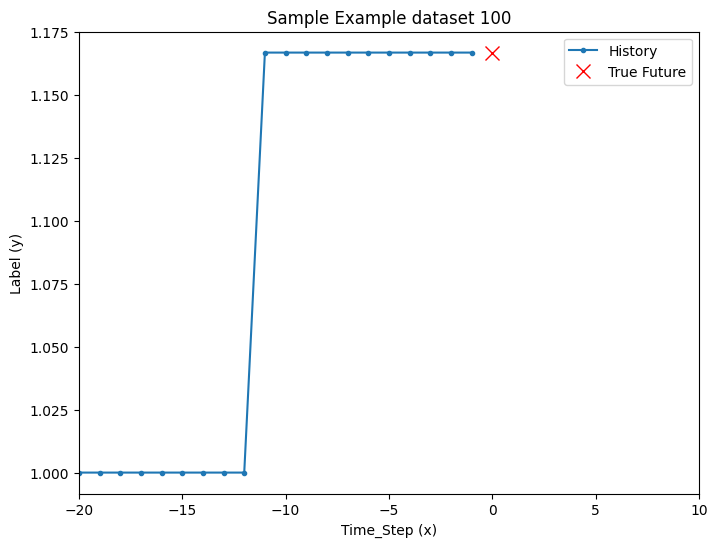

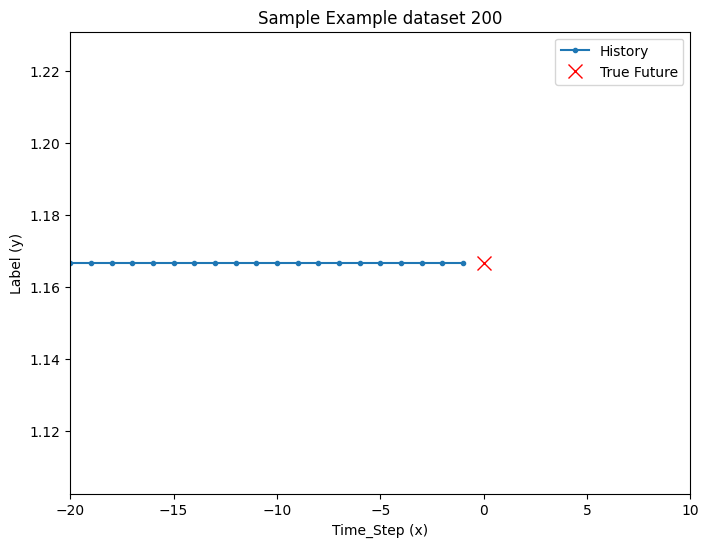

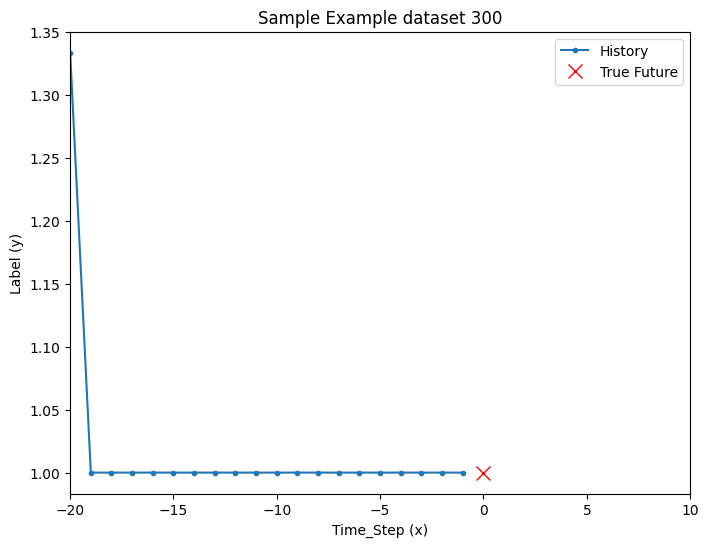

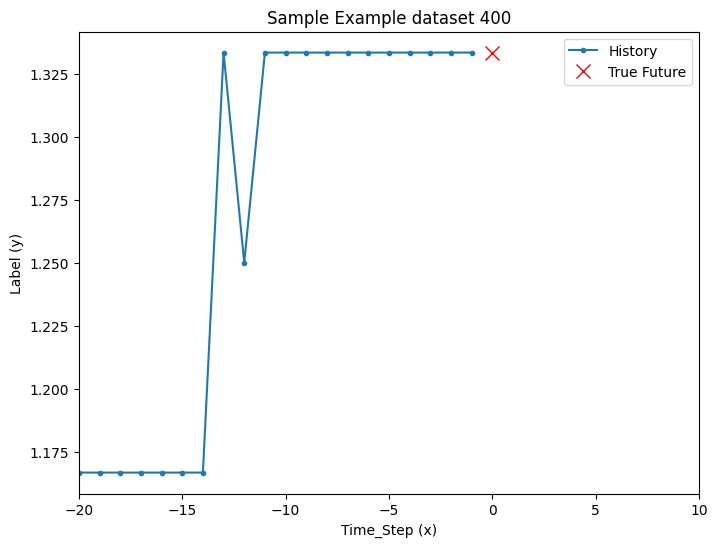

In [186]:
n_data = [0, 100, 200, 300, 400]
for i in n_data:
    plot = plot_time_series([x_train[i] , y_train[i]] , 0 , f'Sample Example dataset {i}')
    plot.show()

In [10]:
value_train = {}
for i, j in enumerate(x_train[0]):
    value_train[f"x{i+1}"] = [j]

value_train['y'] = y_validation[0]

df_windows = pd.DataFrame(value_train)
df_windows.sample(20, replace=True)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,...,1.166667,1.166667,1.166667,1.166667,1.083333,1.083333,1.0,1.0,1.0,2.0
0,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,...,1.166667,1.166667,1.166667,1.166667,1.083333,1.083333,1.0,1.0,1.0,2.0
0,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,...,1.166667,1.166667,1.166667,1.166667,1.083333,1.083333,1.0,1.0,1.0,2.0
0,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,...,1.166667,1.166667,1.166667,1.166667,1.083333,1.083333,1.0,1.0,1.0,2.0
0,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,...,1.166667,1.166667,1.166667,1.166667,1.083333,1.083333,1.0,1.0,1.0,2.0
0,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,...,1.166667,1.166667,1.166667,1.166667,1.083333,1.083333,1.0,1.0,1.0,2.0
0,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,...,1.166667,1.166667,1.166667,1.166667,1.083333,1.083333,1.0,1.0,1.0,2.0
0,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,...,1.166667,1.166667,1.166667,1.166667,1.083333,1.083333,1.0,1.0,1.0,2.0
0,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,...,1.166667,1.166667,1.166667,1.166667,1.083333,1.083333,1.0,1.0,1.0,2.0
0,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,1.166667,...,1.166667,1.166667,1.166667,1.166667,1.083333,1.083333,1.0,1.0,1.0,2.0


In [11]:
# cek dimensi data yang sudah dibuat menjadi window dataset
print(f"x train : {x_train.shape}")
print(f"y train : {y_train.shape}")
print(f"x validation : {x_validation.shape}")
print(f"y validation : {y_validation.shape}")

x train : (835, 20)
y train : (835,)
x validation : (194, 20)
y validation : (194,)


In [12]:
# reshape data
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_validation = np.reshape(x_validation, (x_validation.shape[0], 1, x_validation.shape[1]))

In [13]:
# cek dimensi data yang sudah dibuat menjadi window dataset
print(f"x train : {x_train.shape}")
print(f"y train : {y_train.shape}")
print(f"x validation : {x_validation.shape}")
print(f"y validation : {y_validation.shape}")

x train : (835, 1, 20)
y train : (835,)
x validation : (194, 1, 20)
y validation : (194,)


In [14]:
## prepare tensorflow dataset
batch_size = 256
buffer_size = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train , y_train))
train_dataset = train_dataset.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((x_validation , y_validation))
val_dataset = val_dataset.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_dataset)
print(val_dataset)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 20), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 20), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [15]:
# membuat model lstm menggunakan keras
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.LSTM(20, input_shape=(1, window_size))),
model.add(tf.keras.layers.Dense(1))

In [193]:
# model.load_weights('../model/lstm_model_heigth2.h5')

In [16]:
# set loss dan optimizer training data
optimizer = 'adam'

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# train model
steps = 200
EPOCHS = 50
history = model.fit(train_dataset , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_dataset, validation_steps = 50)

Epoch 1/50
200/200 [==============================] - 3s 5ms/step - loss: 0.2269 - mae: 0.2718 - val_loss: 0.0075 - val_mae: 0.0550
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0073 - mae: 0.0622 - val_loss: 0.0084 - val_mae: 0.0569
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0045 - mae: 0.0423 - val_loss: 0.0092 - val_mae: 0.0620
Epoch 4/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0038 - mae: 0.0372 - val_loss: 0.0083 - val_mae: 0.0607
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0033 - mae: 0.0341 - val_loss: 0.0064 - val_mae: 0.0525
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0027 - mae: 0.0309 - val_loss: 0.0048 - val_mae: 0.0451
Epoch 7/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0023 - mae: 0.0275 - val_loss: 0.0031 - val_mae: 0.0331
Epoch 8/50
200/200 [==============================] - 1s 3ms/step - loss: 0.

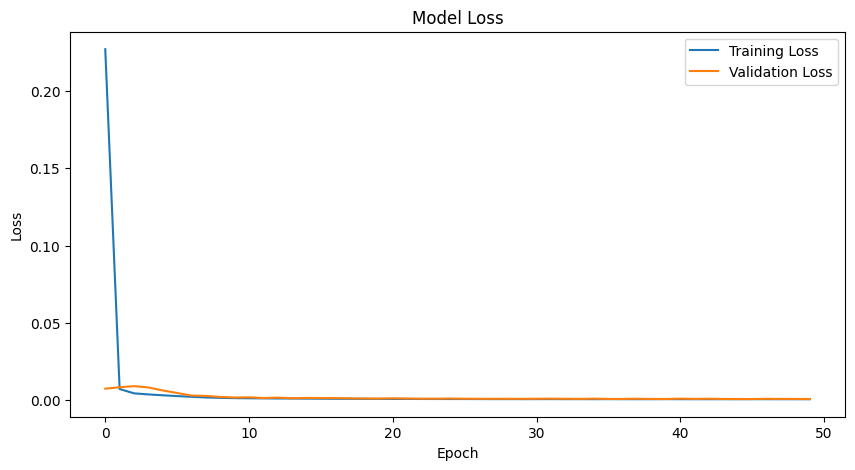

In [17]:
# Plot loss and accuracy selama training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [196]:
# save weight
# model.save('../model/lstm_model.h5')
# model.save_weights('../model/lstm_model_heigth2.h5')


In [18]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_validation)

# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_validation])

# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


7/7 [==============================] - 0s 2ms/step
Train Score: 156.10 RMSE
Test Score: 173.56 RMSE


In [19]:
def calculate_mape(actual, predicted) -> float: 
  mape = np.mean(np.abs((actual - predicted)/actual))*100
  return mape

In [20]:
# calculate root mean squared error
trainScore = calculate_mape(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAPE' % (trainScore))
testScore = calculate_mape(testY[0], testPredict[:,0])
print('Test Score: %.2f MAPE' % (testScore))
# print(trainY[0])
# print(trainPredict[:,0])

Train Score: 0.42 MAPE
Test Score: 0.62 MAPE


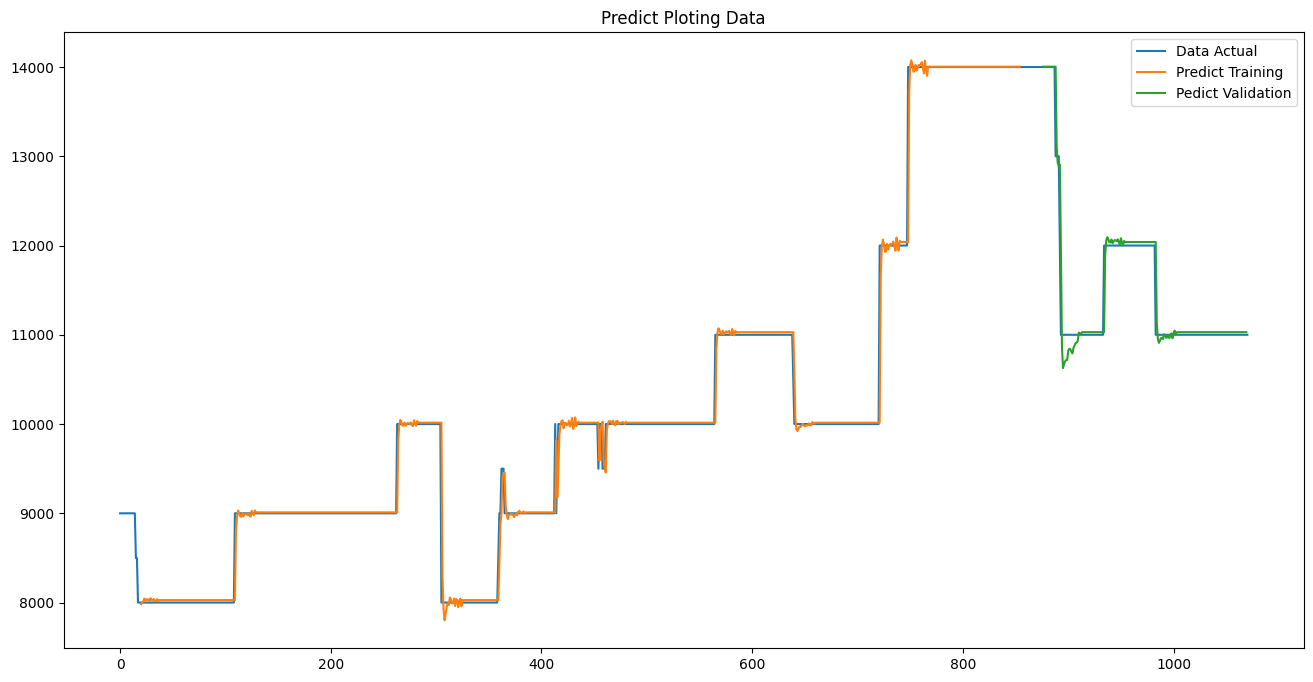

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(min_max_scaler.inverse_transform(dataset), label='Data Actual')
plt.plot(trainPredictPlot, label='Predict Training')
plt.plot(testPredictPlot, label='Pedict Validation')
plt.title('Predict Ploting Data')
plt.legend()
plt.show()

1/1 [==============================] - 0s 28ms/step


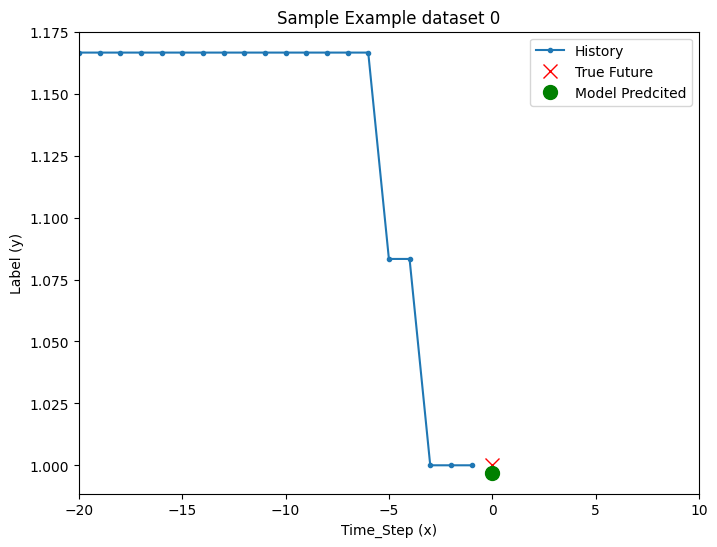

1/1 [==============================] - 0s 28ms/step


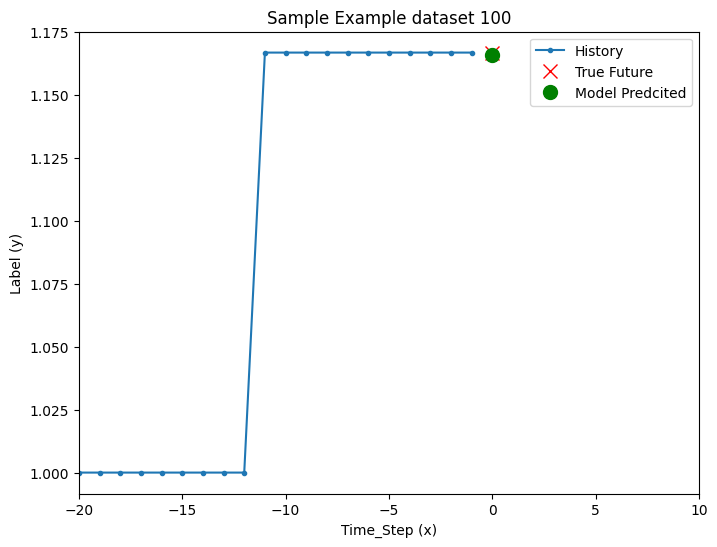

1/1 [==============================] - 0s 35ms/step


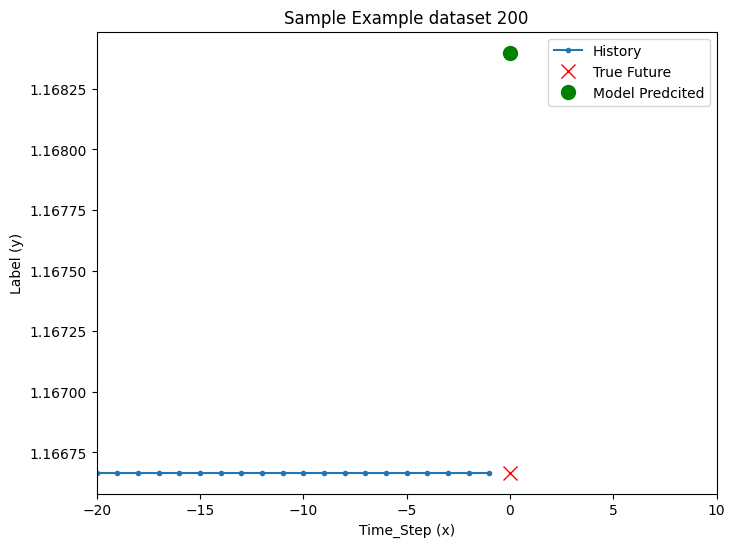

1/1 [==============================] - 0s 32ms/step


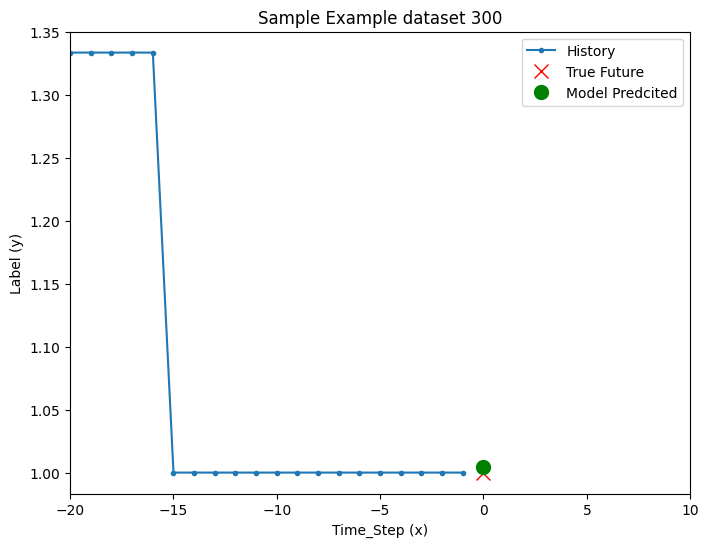

1/1 [==============================] - 0s 37ms/step


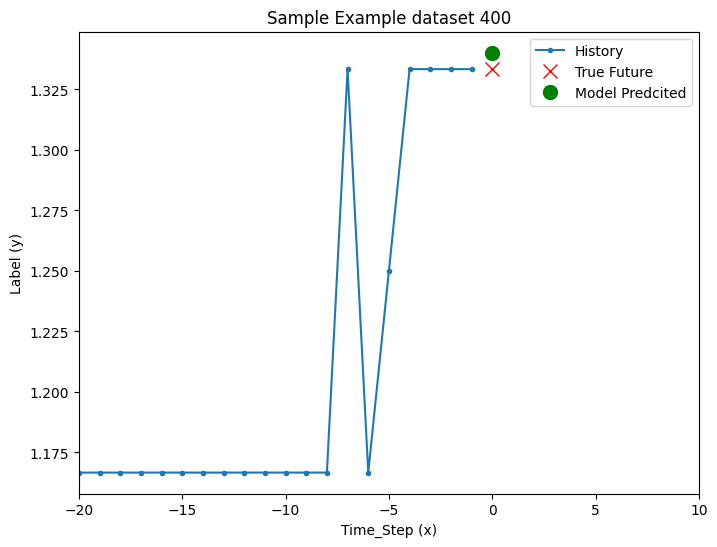

In [22]:
# x_train[0].reshape(-1)
n_data = [0, 100, 200, 300, 400]
for i in n_data:
    # print(x_train[i].shape)
    dapapred = np.reshape(x_train[i], (x_train[i].shape[0], 1, x_train[i].shape[1]))
    # print(dapapred.shape)
    # print(dapapred.shape)
    plot = plot_time_series([x_train[i].reshape(-1) , y_train[i], model.predict(dapapred)] , 0 , f'Sample Example dataset {i}')
    plot.show()

In [23]:
data_awal_predict = dataset[-20:]
data_awal_predict_reshape = np.reshape(data_awal_predict, (data_awal_predict.shape[1], 1, data_awal_predict.shape[0]))
data_awal_predict_reshape.shape

# dp = np.append(data_awal_predict_reshape, 2.)
# # dp_reshape = dp.reshape(dp, (1, 1, 20))

# print(data_awal_predict)
# print(data_awal_predict.shape)

# print(data_awal_predict_reshape)
# print(data_awal_predict_reshape.shape)


# print(dp[-20:])
# print(dp[-20:].shape)
# for i in range(10):
#     np.append(data_awal_predict, model.predict(data_awal_predict[-20:]))

# data_awal_predict = np.reshape(data_awal_predict, (data_awal_predict.shape[1], 1, data_awal_predict.shape[0]))
# # data_awal_predict.shape

# model.predict(data_awal_predict)

# print(x_train.shape)
# for i in range(10):
#     print(x_train[i])



(1, 1, 20)

In [24]:
data_awal = data[window_size:500+window_size]
data_predict = trainPredict[:500]

# data_predict
new_df = {
    "tanggal" : data_awal.index,
    "data aktual" : data_awal.values.reshape(-1),
    "data prediksi": data_predict.reshape(-1)
}

dataframe = pd.DataFrame(new_df)
dataframe.sample(20)


,tanggal,data aktual,data prediksi
349,2022-01-05,9000.0,8979.921875
262,2021-10-10,10000.0,10033.055664
410,2022-03-07,10000.0,9943.654297
292,2021-11-09,8000.0,7972.125488
434,2022-03-31,9500.0,10015.368164
236,2021-09-14,9000.0,9010.396484
353,2022-01-09,9000.0,8990.889648
241,2021-09-19,9000.0,9010.396484
135,2021-06-05,9000.0,9010.396484
307,2021-11-24,8000.0,8027.866699
